In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
from tensorflow.keras import layers, models


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
tf.enable_eager_execution()

## Settings

In [4]:
DTYPE=tf.float32
NP_DTYPE=np.float32
BATCH_SIZE=3

In [141]:
class PiecewiseLinear(tfb.Bijector):
    """
    Piecewise Linear: based on 1808.03856
    """
    def __init__(self, D, d, nbins, layer_id=0, validate_args=False, name="PiecewiseLinear"):
        """
        Args:
            D: number of dimensions
            d: First d units are pass-thru units.
        """
        super(PiecewiseLinear, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        self.nbins = nbins
        self.width = 1.0/self.nbins
        self.range = np.arange(self.d)
        self.QMat = self.buildQ(self.d, self.nbins)
        self.trainable_variables = self.QMat.trainable_variables
        
    def buildQ(self, d, nbins):
        inval = layers.Input(shape=(d,))
        h1 = layers.Dense(64,activation='relu')(inval)
        h2 = layers.Dense(64,activation='relu')(h1)
        out = layers.Dense(d*nbins,activation='relu')(h2)
        out = layers.Reshape((d,nbins))(out)
        model = models.Model(inval,out)
        model.summary()
        return model
        
    def Q(self, xd):
        QMat = tf.nn.softmax(self.QMat(xd),axis=2)
        QMat = np.insert(QMat,0,0,axis=2)
        return QMat
        
    def pdf(self,x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = np.array(np.floor(xD*self.nbins),dtype=np.int32)+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        return tf.concat([xd, tf.gather_nd(Q,bins)/self.width], axis=1)
        
    def _forward(self, x):
        "Calculate forward coupling layer"
        xd, xD = x[:, :self.d], x[:, self.d:]
        Q = self.Q(xd)
        ibins = np.array(np.floor(xD*self.nbins),dtype=np.int32)
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        yD = (xD*self.nbins-ibins)*tf.gather_nd(Q,bins)+tf.gather_nd(np.cumsum(Q,axis=2),binsSum)
        return tf.concat([xd, yD], axis=1)
        
    def _inverse(self, y):
        "Calculate inverse coupling layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.searchsorted(np.cumsum(Q,axis=2),yD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
        xD = ((yD-tf.gather_nd(np.cumsum(Q,axis=2),binsSum))*tf.reciprocal(tf.gather_nd(Q,bins))\
              +np.array(ibins,dtype=np.float32))*self.width
        xD = tf.where(tf.is_nan(xD), tf.ones_like(xD), xD)
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        "Calculate log determinant of Coupling Layer"
        return tf.reduce_sum(tf.log(self.pdf(x)[:,self.d:]),axis=-1)
    
    def _inverse_log_det_jacobian(self, y):
        "Calculate log determinant of Coupling Layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        Q = self.Q(yd)
        ibins = tf.searchsorted(np.cumsum(Q,axis=2),yD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        return -tf.reduce_sum(tf.log(tf.gather_nd(Q,bins)/self.width),axis=-1)

In [142]:
test = PiecewiseLinear(6,3,5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_62 (Dense)             (None, 15)                975       
_________________________________________________________________
reshape_20 (Reshape)         (None, 3, 5)              0         
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [115]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test._forward(val)
inverse = test._inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [42]:
np.allclose(test._forward_log_det_jacobian(val),-test._inverse_log_det_jacobian(forward))

True

In [70]:
WMat = np.random.rand(3,5)
WMat = tf.nn.softmax(WMat)
WMat = np.insert(WMat,0,0,axis=1)
WMat

array([[0.        , 0.17456913, 0.22694462, 0.2429675 , 0.15324998,
        0.20226877],
       [0.        , 0.24679232, 0.24172327, 0.26217076, 0.13979937,
        0.10951428],
       [0.        , 0.21056773, 0.1838972 , 0.15401986, 0.24073882,
        0.21077639]])

In [71]:
# randomly assign unnormalized values to piecewise PDF, here we will be using a total of 6 dimensions (|B|=3)
VMat = np.random.rand(3,6)
expV = tf.exp(VMat)
VDenom = np.sum(0.5*(expV[:,0:5]+expV[:,1:6])*WMat[:,1:6],axis=1,keepdims=True)
# normalize the piecewise PDF such that the integral is 1
VMat = np.true_divide(expV,VDenom)
VMat = np.insert(VMat,0,0,axis=1)
# Print out values of Q for testing purposes
print(np.cumsum((VMat[:,1:7]+VMat[:,0:6])*WMat/2.0,axis=1))
VMat

[[0.         0.20387799 0.3962557  0.60170353 0.76497245 1.        ]
 [0.         0.21190974 0.47732211 0.72869396 0.86163553 1.        ]
 [0.         0.249873   0.4628639  0.61603303 0.81612674 1.        ]]


array([[0.        , 1.31495238, 1.02083272, 0.67453863, 1.01661622,
        1.1141367 , 1.20977673],
       [0.        , 0.77589487, 0.94141741, 1.25458438, 0.66303494,
        1.23885577, 1.28801967],
       [0.        , 1.21681733, 1.15650936, 1.15990323, 0.82904978,
        0.83328048, 0.91144297]])

In [122]:
# network in the coupling layer
def netV(x, outsize, nbins):
    # Note: Need to put in actual matrix, this is just to test
    return VMat

# network in the coupling layer
def netW(x, outsize, nbins):
    # Note: Need to put in actual matrix, this is just to test
    return WMat

class PiecewiseQuadratic(tfb.Bijector):
    """
    Piecewise Quadratic: based on 1808.03856
    """
    def __init__(self, D, d, nbins, layer_id=0, validate_args=False, name="PiecewiseLinear"):
        """
        Args:
            D: number of dimensions
            d: First d units are pass-thru units.
        """
        super(PiecewiseQuadratic, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name
        )
        self.D, self.d = D, d
        self.id = layer_id
        self.nbins = nbins
        self.range = np.arange(self.d)
        self.WMat = self.buildW(self.d, self.nbins)
        self.VMat = self.buildV(self.d, self.nbins)
        self.trainable_variables = [
            self.WMat.trainable_variables,
            self.VMat.trainable_variables,
        ]
        
    def buildW(self, d, nbins):
        inval = layers.Input(shape=(d,))
        h1 = layers.Dense(64,activation='relu')(inval)
        h2 = layers.Dense(64,activation='relu')(h1)
        out = layers.Dense(d*nbins,activation='relu')(h2)
        out = layers.Reshape((d,nbins))(out)
        model = models.Model(inval,out)
        return model
    
    def buildV(self, d, nbins):
        inval = layers.Input(shape=(d,))
        h1 = layers.Dense(64,activation='relu')(inval)
        h2 = layers.Dense(64,activation='relu')(h1)
        out = layers.Dense(d*(nbins+1),activation='relu')(h2)
        out = layers.Reshape((d,nbins+1))(out)
        model = models.Model(inval,out)
        return model
        
    def W(self, xd):
        WMat = tf.nn.softmax(self.WMat(xd),axis=2)
        WMat = np.insert(WMat,0,0,axis=2)
        return WMat
              
    def V(self, xd, W):
        VMat = self.VMat(xd)
        VExp = tf.exp(VMat)
        VSum = np.sum((VExp[...,0:self.nbins]+VExp[...,1:self.nbins+1])*W[...,1:self.nbins+1]/2,axis=2,keepdims=True)
        VMat = np.true_divide(VExp,VSum)
        VMat = np.insert(VMat,0,0,axis=2)
        return VMat
        
    def pdf(self,x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        W = self.W(xd)
        V = self.V(xd,W)
        WSum = np.cumsum(W,axis=2)
        ibins = tf.searchsorted(WSum,xD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(xD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        alpha = (xD-tf.gather_nd(WSum,binsSum))*tf.reciprocal(tf.gather_nd(W,bins))
        result = tf.gather_nd(np.diff(V),bins)*alpha+tf.gather_nd(V,bins)
        return tf.concat([xd, result], axis=1) 
        
    def _forward(self, x):
        "Calculate forward coupling layer"
        xd, xD = x[:, :self.d], x[:, self.d:]
        W = self.W(xd)
        V = self.V(xd,W)
        WSum = np.cumsum(W,axis=2)
        VSum = np.cumsum((V[...,1:]+V[...,0:-1])*W/2.0,axis=2)
        ibins = tf.searchsorted(WSum,xD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(xD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(xD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
        alpha = (xD-tf.gather_nd(WSum,binsSum))/tf.gather_nd(W,bins)
        yD = alpha**2/2*tf.gather_nd(np.diff(V),bins)*tf.gather_nd(W,bins) \
           + alpha*tf.gather_nd(V,bins)*tf.gather_nd(W,bins) \
           + tf.gather_nd(VSum,binsSum)
        return tf.concat([xd, yD], axis=1)
    
    def _inverse(self, y):
        "Calculate inverse coupling layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        W = self.W(yd)
        V = self.V(yd,W)
        WSum = np.cumsum(W,axis=2)
        VSum = np.cumsum((V[...,1:]+V[...,0:-1])*W/2.0,axis=2)
        ibins = tf.searchsorted(VSum,yD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
        denom = tf.gather_nd(np.diff(V),bins)
        beta = (yD - tf.gather_nd(VSum,binsSum))/tf.gather_nd(W,bins)
        Vbins = tf.gather_nd(V,bins)
        xD = tf.where(tf.equal(tf.zeros_like(denom),denom),
                      beta/Vbins,
                      1/denom*(-Vbins+tf.sqrt(Vbins**2+2*beta*denom))
                      )
        xD = tf.gather_nd(W,bins)*xD + tf.gather_nd(WSum,binsSum)
        xD = tf.where(tf.is_nan(xD), tf.ones_like(xD), xD)
        return tf.concat([yd, xD], axis=1)
    
    def _forward_log_det_jacobian(self, x):
        "Calculate log determinant of Coupling Layer"
        return tf.reduce_sum(tf.log(self.pdf(x)[:,self.d:]),axis=-1)
    
    def _inverse_log_det_jacobian(self, y):
        "Calculate log determinant of Coupling Layer"
        yd, yD = y[:, :self.d], y[:, self.d:]
        W = self.W(yd)
        V = self.V(yd,W)
        WSum = np.cumsum(W,axis=1)
        VSum = np.cumsum((V[...,1:]+V[...,0:-1])*W/2.0,axis=2)
        ibins = tf.searchsorted(VSum,yD[...,np.newaxis],side='right')
        ibins = ibins.numpy().reshape(len(yD),self.d)
        ibins = ibins-1
        ibinsp1 = ibins+1
        grid = np.array(np.meshgrid(np.arange(len(yD)),self.range)).T
        bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
        binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
        denom = tf.gather_nd(np.diff(V),bins)
        beta = (yD - tf.gather_nd(VSum,binsSum))/tf.gather_nd(W,bins)
        Vbins = tf.gather_nd(V,bins)
        alpha = tf.where(tf.equal(tf.zeros_like(denom),denom),
                      beta/Vbins,
                      1/denom*(-Vbins+tf.sqrt(Vbins**2+2*beta*denom))
                      )
        result = tf.gather_nd(np.diff(V),bins)*alpha+Vbins
        return -tf.reduce_sum(tf.log(result),axis=-1)
        

In [123]:
test = PiecewiseQuadratic(6,3,5)

In [32]:
val = np.array(np.random.rand(10,6),dtype=NP_DTYPE)
forward = test._forward(val)
inverse = test._inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])
print(val)
print(inverse)

False
[8.8300329e-04 1.5766123e-05]
[[3.4720033e-01 3.8520232e-02 9.2774563e-02 8.6780560e-01 9.9189866e-01
  8.3350700e-01]
 [3.6891305e-01 2.6776716e-01 2.3142374e-01 7.1459168e-01 6.1575878e-01
  3.8758315e-02]
 [2.0412132e-01 3.8542879e-01 8.2402903e-01 6.4213477e-02 3.4931684e-01
  9.1361910e-01]
 [2.4279793e-01 4.9276388e-01 8.0102378e-01 8.8438129e-01 9.9923348e-01
  3.9339861e-01]
 [7.5170594e-01 6.3862973e-01 2.1874532e-01 2.7880144e-01 5.2063370e-01
  3.8032091e-01]
 [8.5285509e-01 8.2509643e-01 6.5831971e-01 8.9404571e-01 1.7312402e-01
  5.8223194e-01]
 [9.9406362e-01 8.5793531e-01 7.7747488e-03 9.2783600e-01 8.8955069e-01
  8.0318576e-01]
 [6.8088257e-01 6.2268382e-01 2.8888002e-01 7.6207250e-01 9.8717797e-01
  3.5092563e-04]
 [1.1164971e-01 9.8713499e-01 2.4259631e-01 4.4642139e-02 9.2617726e-01
  5.3559601e-01]
 [7.7620739e-01 8.7989891e-01 5.4129660e-01 2.5725138e-01 7.5138465e-02
  8.7263204e-02]]
tf.Tensor(
[[3.4720033e-01 3.8520232e-02 9.2774563e-02 8.6780560e-01 9.91

In [31]:
x = np.array([0.53468007, 0.23679031, 0.40766907, 0.36751658, 0.0083478326, 0.004279  ],dtype=NP_DTYPE).reshape(1,6)
xd, xD = x[:, :3], x[:, 3:]
W = test.W(xd)
V = test.V(xd,W)
WSum = np.cumsum(W,axis=2)
VSum = np.cumsum((V[...,1:]+V[...,0:-1])*W/2.0,axis=2)
ibins = tf.searchsorted(WSum,xD[...,np.newaxis],side='right')
ibins = ibins.numpy().reshape(len(xD),3)
ibins = ibins-1
ibinsp1 = ibins+1
grid = np.array(np.meshgrid(np.arange(len(xD)),np.arange(3))).T
bins = tf.concat([grid,ibinsp1[np.arange(len(xD)),:,np.newaxis]],axis=2)
binsSum = tf.concat([grid,ibins[np.arange(len(xD)),:,np.newaxis]],axis=2)
alpha = (xD-tf.gather_nd(WSum,binsSum))/tf.gather_nd(W,bins)
print(alpha)
print(tf.gather_nd(W,bins))
yD = alpha**2/2*tf.gather_nd(np.diff(V),bins)*tf.gather_nd(W,bins) \
    + alpha*tf.gather_nd(V,bins)*tf.gather_nd(W,bins) \
    + tf.gather_nd(VSum,binsSum)

print(ibins)
print(yD)
    
ibins = tf.searchsorted(VSum,yD[...,np.newaxis],side='right')
ibins = ibins.numpy().reshape(len(yD),3)
ibins = ibins-1
ibinsp1 = ibins+1
print(ibins)
grid = np.array(np.meshgrid(np.arange(len(yD)),np.arange(3))).T
bins = tf.concat([grid,ibinsp1[np.arange(len(yD)),:,np.newaxis]],axis=2)
binsSum = tf.concat([grid,ibins[np.arange(len(yD)),:,np.newaxis]],axis=2)
denom = tf.gather_nd(np.diff(V),bins)
beta = (yD - tf.gather_nd(VSum,binsSum))/tf.gather_nd(W,bins)
Vbins = tf.gather_nd(V,bins)
xD = tf.where(tf.equal(tf.zeros_like(denom),denom),
                beta/Vbins,
                1/denom*(-Vbins+tf.sqrt(Vbins**2+2*beta*denom))
                )
print(xD)
xD = tf.gather_nd(W,bins)*xD + tf.gather_nd(WSum,binsSum)
xD = tf.where(tf.is_nan(xD), tf.ones_like(xD), xD)
print(xD)

tf.Tensor([[0.8416258  0.04174051 0.02262653]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.19956094 0.19999357 0.1891143 ]], shape=(1, 3), dtype=float32)
[[1 0 0]]
tf.Tensor([[0.3887738  0.00842653 0.00432426]], shape=(1, 3), dtype=float32)
[[1 0 0]]
tf.Tensor([[0.84162587 0.04173959 0.02262794]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.36751658 0.00834765 0.00427927]], shape=(1, 3), dtype=float32)


In [33]:
print((val-inverse.numpy())/val)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.20640276e-07  1.43021339e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.93597387e-07  3.46017237e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.48084910e-07
  -1.70632035e-07  6.52401440e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.69587986e-07
  -2.38601473e-07 -4.54536263e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.34472179e-07
   0.00000000e+00  7.83609906e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.66684556e-08
  -6.02505224e-07  2.35457173e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.42404956e-08
   0.00000000e+00 -2.22630860e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.83003289e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.34478442e-07
  -3.86133280e-07 -1.11286575e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.47547086e-07
   1.57661234e-05 -8.5380

In [8]:
forward_jacobian = test._forward_log_det_jacobian(val)
inverse_jacobian = test._inverse_log_det_jacobian(forward)
difference = forward_jacobian+inverse_jacobian
print(np.allclose(forward_jacobian,-inverse_jacobian))
print((difference/forward_jacobian).numpy()[np.logical_not(np.isclose(forward_jacobian,-inverse_jacobian))])

False
[-3.65906744e-05  2.31495305e-05 -1.91432628e-05  1.53121255e-05
 -1.46974326e-05 -1.67471881e-05  1.53521705e-05 -3.90705682e-05
 -1.16414321e-05  8.47753690e-05  6.25780813e-05 -2.78821972e-05
  1.72290202e-05 -1.54693262e-05  6.21329382e-05 -1.79391918e-05
  1.34934025e-05  2.06720233e-05 -7.73070351e-05  1.29212785e-05
  1.24321095e-05 -2.63154325e-05  1.64271914e-05  1.10517474e-04
 -1.89330040e-05  2.68329713e-05 -1.55543585e-05  2.18707108e-04
 -1.26716632e-05 -5.63975736e-05 -2.17211236e-05  1.61007592e-05
 -6.99047669e-05]


In [160]:
bijectors = []

for i in range(2):
    bijectors.append(PiecewiseLinear(2,1,5,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_76 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_77 (Dense)             (None, 5)                 325       
_________________________________________________________________
reshape_25 (Reshape)         (None, 1, 5)              0         
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27

In [161]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

In [162]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

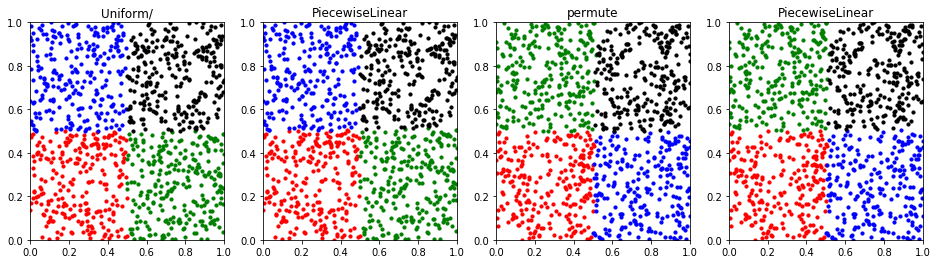

In [163]:
f, arr = plt.subplots(1, len(samples), figsize=(4*len(samples),4))
X0 = samples[0].numpy()
for i in range(len(samples)):
    X1 = samples[i].numpy()
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [164]:
def dsigma(x):
    return tf.where(np.logical_and(x[:,0] < np.ones_like(x[:,0])*0.9,x[:,1] < np.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), np.zeros_like(x[:,0]))

In [165]:
samples = np.array(np.random.rand(1000,2),dtype=NP_DTYPE)
x = bijector.inverse(samples)
X = bijector.pdf(x)
dsig = dsigma(x)
print(tf.reduce_prod(X,axis=-1), '\n', dsig)

tf.Tensor(
[0.50868315 0.19002455 0.49499726 0.86940897 0.21817303 1.018231
 0.71203685 0.9141156  0.9908575  0.40989432 0.17891505 0.47341225
 0.33268487 0.7077338  0.41432306 0.4293134  0.14075835 0.51145977
 0.6572349  0.3535929  0.22096866 0.38204247 0.09866763 0.8893694
 0.5236993  0.35003617 1.0414289  0.72864205 0.08749794 0.6260667
 0.36858416 0.291443   0.32017958 0.12808877 0.2878014  0.7098302
 0.42491442 0.48026654 0.9829343  0.2582002  0.40324524 0.4209217
 0.16988598 0.7116816  0.6376277  0.4961611  0.47989216 0.7791909
 0.10361455 0.4311784  0.11911344 0.21295862 0.26741606 0.27136043
 0.3005633  0.4877625  0.18803735 0.90323603 0.9123633  0.84592366
 0.2194299  0.6663656  0.7441445  0.71527034 0.25496164 0.14595959
 0.60809606 1.1275607  0.41164804 0.44395354 0.49920005 0.01852336
 0.32914418 0.54958206 0.39660683 0.92276335 0.81712514 0.68254906
 0.5952455  0.01790674 0.6290666  0.43368956 0.78958786 0.9950074
 0.93268883 0.33662558 0.07431995 0.19993299 0.35225496 0.6

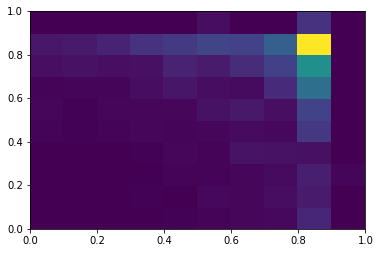

In [130]:
plt.hist2d(x[:,0],x[:,1],weights=dsig)
plt.show()

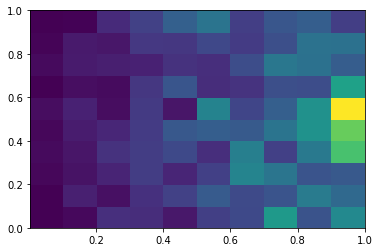

In [166]:
plt.hist2d(x[:,0],x[:,1],weights=tf.reduce_prod(X,axis=-1)*tf.exp(bijector.forward_log_det_jacobian(x,event_ndims=1)))
plt.show()

In [167]:
loss = -tf.reduce_mean(dsig*tf.log(tf.reduce_prod(X,axis=-1)))
print(loss)

tf.Tensor(2.2859654, shape=(), dtype=float32)


In [168]:
def loss_fn(x):
    x = bijector.inverse(x)
    q = tf.reduce_prod(bijector.pdf(x),axis=-1)
    p = dsigma(x)
    return -tf.reduce_mean(p*(tf.log(q)+bijector.forward_log_det_jacobian(x,event_ndims=1)))

In [169]:
def grad(x):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x)
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [170]:
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.Variable(0)

loss_value, grads = grad(samples)

print(loss_value, grads)


tf.Tensor(2.3752754, shape=(), dtype=float32) [None, None, None, None, None, None]


In [171]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [172]:
model.trainable_variables

[<tf.Variable 'dense_81/kernel:0' shape=(4, 10) dtype=float32, numpy=
 array([[ 0.35737205,  0.03949726,  0.46700406, -0.05805957,  0.01121163,
          0.02425838,  0.47517562, -0.61134475,  0.02349681, -0.4196068 ],
        [-0.12737364, -0.33167621,  0.27332824,  0.30831861, -0.1058889 ,
          0.29416025,  0.0975638 , -0.59358364,  0.16745102,  0.05841976],
        [ 0.48076725, -0.02115309,  0.12746823, -0.43882436, -0.55728406,
         -0.47280347, -0.38851926,  0.453714  , -0.5348476 ,  0.1656825 ],
        [ 0.24569368,  0.21493948, -0.17015469, -0.50531936, -0.41703862,
          0.31344056,  0.503955  ,  0.4311651 ,  0.55358696,  0.15586853]],
       dtype=float32)>,
 <tf.Variable 'dense_81/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_82/kernel:0' shape=(10, 10) dtype=float32, numpy=
 array([[ 0.1717785 , -0.23898536, -0.52360314, -0.5128485 , -0.36362642,
         -0.25089177, -0.39319974,

In [173]:
bijector.trainable_variables

[<tf.Variable 'dense_78/kernel:0' shape=(1, 64) dtype=float32, numpy=
 array([[-0.13553208,  0.04945064,  0.19295466,  0.2933039 ,  0.27532417,
         -0.18959895, -0.00385872, -0.11247981, -0.04038739, -0.03783378,
         -0.22702187,  0.3036902 ,  0.17742828, -0.2478121 , -0.18496054,
         -0.26660842, -0.13032807, -0.10682394, -0.22881773,  0.23474818,
          0.05251136, -0.1523516 , -0.2768236 ,  0.15502888, -0.2600781 ,
         -0.07928167,  0.15681428,  0.11476526,  0.00676677, -0.2537851 ,
         -0.1796762 , -0.29289907, -0.24244367, -0.17731708,  0.01791447,
          0.02186063, -0.06585233, -0.22793575,  0.26808548,  0.23836613,
          0.02056703, -0.20731017, -0.13114002, -0.05402102,  0.22268146,
          0.01597384, -0.12234199,  0.24144018,  0.21583128,  0.12378046,
         -0.17926723, -0.28831562,  0.07408997, -0.09445617, -0.01322594,
          0.1076369 ,  0.28793705, -0.24253407,  0.03502664,  0.26868975,
          0.14506504, -0.14946724, -0.2501